In [1]:
import sys
print(sys.version)

3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]


In [48]:
# Importing dependencies

import os
os.environ['PYTHONHASHSEED'] = '0'
import random as rn
import numpy as np
np.random.seed(1)
rn.seed(3)
import tensorflow
tensorflow.random.set_seed(2)
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import SimpleRNN
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from keras.layers.recurrent import GRU
from math import sqrt
import datetime as dt
import time
plt.style.use('ggplot')

## Dataset Preprocessing and Feature Extraction

In [3]:
# Loading the dataset
df = pd.read_excel('C:/Users/sucha/Documents/Sucharita/Upgrad_Research/Research/Forex_with_News_data.xlsx', sheet_name="MarketData")
df.tail()

,Date,"EUR/USD(Open, Ask)","EUR/USD(High, Ask)","EUR/USD(Low, Ask)","EUR/USD(Close, Ask)","EUR/USD(Open, Bid)","EUR/USD(High, Bid)","EUR/USD(Low, Bid)","EUR/USD(Close, Bid)",Difference in Close Bid in 4 hours,Class A,Class B,Class C,Class D,Group name based on Class,MAX of difference(i.e. J),MIN of difference(i.e. J),Class,Bottom Value,Top Value
15088,2007-11-23 01:00:00,1.49240,1.49380,1.4906,1.49090,1.4921,1.49350,1.49027,1.4906,-0.0036,NaN,NaN,NaN,D,D,NaN,NaN,NaN,NaN,NaN
15089,2007-11-22 23:00:00,1.49450,1.49490,1.4924,1.49240,1.4942,1.49460,1.49210,1.4921,0.0064,NaN,NaN,C,NaN,C,NaN,NaN,NaN,NaN,NaN
15090,2007-11-22 21:00:00,1.48600,1.49700,1.4860,1.49450,1.4857,1.49660,1.48570,1.4942,0.0097,NaN,NaN,C,NaN,C,NaN,NaN,NaN,NaN,NaN
15091,2007-11-22 19:00:00,1.48489,1.48615,1.4847,1.48600,1.4845,1.48590,1.48440,1.4857,1.4857,A,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN
15092,2007-11-22 17:00:00,1.48548,1.48580,1.4845,1.48489,1.4851,1.48545,1.48394,1.4845,1.4845,A,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

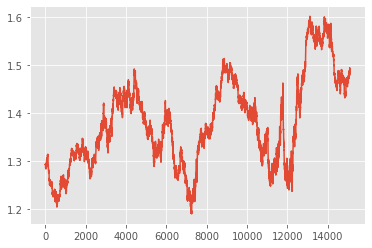

In [4]:
df['EUR/USD(Close, Bid)'].plot()

In [5]:
# Correlation matrix
df.corr()['EUR/USD(Close, Bid)']

EUR/USD(Open, Ask)                    0.999494
EUR/USD(High, Ask)                    0.999750
EUR/USD(Low, Ask)                     0.999760
EUR/USD(Close, Ask)                   1.000000
EUR/USD(Open, Bid)                    0.999495
EUR/USD(High, Bid)                    0.999750
EUR/USD(Low, Bid)                     0.999760
EUR/USD(Close, Bid)                   1.000000
Difference in Close Bid in 4 hours    0.017810
Class B                                    NaN
MAX of difference(i.e. J)                  NaN
MIN of difference(i.e. J)                  NaN
Name: EUR/USD(Close, Bid), dtype: float64

In [6]:
# Setting up an early stop
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]

In [7]:
df = df.set_index('Date')

In [8]:
# Reverse the order 
df = pd.DataFrame(df.iloc[::-1])
df.head()

,"EUR/USD(Open, Ask)","EUR/USD(High, Ask)","EUR/USD(Low, Ask)","EUR/USD(Close, Ask)","EUR/USD(Open, Bid)","EUR/USD(High, Bid)","EUR/USD(Low, Bid)","EUR/USD(Close, Bid)",Difference in Close Bid in 4 hours,Class A,Class B,Class C,Class D,Group name based on Class,MAX of difference(i.e. J),MIN of difference(i.e. J),Class,Bottom Value,Top Value
Date,,,,,,,,,,,,,,,,,,,
2007-11-22 17:00:00,1.48548,1.48580,1.4845,1.48489,1.4851,1.48545,1.48394,1.4845,1.4845,A,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN
2007-11-22 19:00:00,1.48489,1.48615,1.4847,1.48600,1.4845,1.48590,1.48440,1.4857,1.4857,A,NaN,NaN,NaN,A,NaN,NaN,NaN,NaN,NaN
2007-11-22 21:00:00,1.48600,1.49700,1.4860,1.49450,1.4857,1.49660,1.48570,1.4942,0.0097,NaN,NaN,C,NaN,C,NaN,NaN,NaN,NaN,NaN
2007-11-22 23:00:00,1.49450,1.49490,1.4924,1.49240,1.4942,1.49460,1.49210,1.4921,0.0064,NaN,NaN,C,NaN,C,NaN,NaN,NaN,NaN,NaN
2007-11-23 01:00:00,1.49240,1.49380,1.4906,1.49090,1.4921,1.49350,1.49027,1.4906,-0.0036,NaN,NaN,NaN,D,D,NaN,NaN,NaN,NaN,NaN


In [9]:
df.isna().sum()

EUR/USD(Open, Ask)                        0
EUR/USD(High, Ask)                        0
EUR/USD(Low, Ask)                         0
EUR/USD(Close, Ask)                       0
EUR/USD(Open, Bid)                        0
EUR/USD(High, Bid)                        0
EUR/USD(Low, Bid)                         0
EUR/USD(Close, Bid)                       0
Difference in Close Bid in 4 hours        0
Class A                               15091
Class B                               15093
Class C                                7514
Class D                                7581
Group name based on Class                 0
MAX of difference(i.e. J)             15092
MIN of difference(i.e. J)             15092
Class                                 15089
Bottom Value                          15089
Top Value                             15089
dtype: int64

In [10]:
df = df.drop(['Class A', 'Class B', 'Class C', 'Class D', 'Group name based on Class', 'MAX of difference(i.e. J)', 'MIN of difference(i.e. J)',
        'Class', 'Bottom Value', 'Top Value','Difference in Close Bid in 4 hours'], axis = 1)
df.rename(columns = {'EUR/USD(Open, Ask)':'open_ask', 'EUR/USD(High, Ask)':'high_ask', 'EUR/USD(Low, Ask)':'low_ask','EUR/USD(Close, Ask)':'close_ask',
                           'EUR/USD(Open, Bid)':'open_bid','EUR/USD(High, Bid)':'high_bid','EUR/USD(Low, Bid)':'low_bid','EUR/USD(Close, Bid)':'close_bid'}, inplace = True)
df.head(2)

,open_ask,high_ask,low_ask,close_ask,open_bid,high_bid,low_bid,close_bid
Date,,,,,,,,
2007-11-22 17:00:00,1.48548,1.48580,1.4845,1.48489,1.4851,1.48545,1.48394,1.4845
2007-11-22 19:00:00,1.48489,1.48615,1.4847,1.48600,1.4845,1.48590,1.48440,1.4857


In [11]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    #df_new['open'] = df['open_bid']
    df_new['open_1'] = df['open_bid'].shift(360)
    df_new['close_1'] = df['close_bid'].shift(360)
    df_new['high_1'] = df['high_bid'].shift(360)
    df_new['low_1'] = df['low_bid'].shift(360)
    
    # 50 original features
    # average price
    df_new['avg_price_5'] = df['close_bid'].rolling(window=5).mean().shift(360)
    df_new['avg_price_30'] = df['close_bid'].rolling(window=30).mean().shift(360)
    df_new['avg_price_90'] = df['close_bid'].rolling(window=90).mean().shift(360)
    df_new['avg_price_365'] = df['close_bid'].rolling(window=365).mean().shift(360)
    
                                               
                                                   
    # return
    df_new['return_1'] = ((df['close_bid'] - df['close_bid'].shift(1)) / df['close_bid'].shift(1)).shift(360)
    df_new['return_5'] = ((df['close_bid'] - df['close_bid'].shift(5)) / df['close_bid'].shift(5)).shift(360)
    df_new['return_30'] = ((df['close_bid'] - df['close_bid'].shift(30)) / df['close_bid'].shift(30)).shift(360)
    df_new['return_90'] = ((df['close_bid'] - df['close_bid'].shift(90)) / df['close_bid'].shift(90)).shift(360)                                                
    df_new['return_365'] = ((df['close_bid'] - df['close_bid'].shift(365)) / df['close_bid'].shift(365)).shift(360)
    
    #average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=30).mean()
    df_new['moving_avg_90'] = df_new['return_1'].rolling(window=90).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=365).mean()
    
       
    # the target
    df_new['close'] = df['close_bid']
    df_new = df_new.dropna(axis=0)
    return df_new

data_new = generate_features(df)

In [12]:
data_new.head(2)

,open_1,close_1,high_1,low_1,avg_price_5,avg_price_30,avg_price_90,avg_price_365,return_1,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_90,moving_avg_365,close
Date,,,,,,,,,,,,,,,,,,
2008-02-20 01:00:00,1.47133,1.47079,1.47169,1.47059,1.471720,1.470775,1.470403,1.464040,-0.000367,-0.000483,-0.002597,0.009874,-0.009235,-0.000096,-0.000086,0.00011,-0.000024,1.47110
2008-02-20 03:00:00,1.47079,1.46905,1.47105,1.46784,1.471154,1.470603,1.470504,1.463994,-0.001183,-0.001923,-0.003493,0.006212,-0.011207,-0.000385,-0.000116,0.00007,-0.000030,1.46996


In [13]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(SimpleRNN(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                        activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(SimpleRNN(hl[i],activation = 'relu',return_sequences = True))
    model.add(SimpleRNN(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [14]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat
  

In [15]:
# Plotting the predictions
def plot_data(Y_test,Y_hat, Title):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title(Title)
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [16]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

## Model Building

In [17]:
# Extracting the series
series = data_new[['close','open_1','close_1','high_1','low_1','avg_price_5','avg_price_30','avg_price_90','avg_price_365','return_1',
             'return_5','return_30','return_90','return_365','moving_avg_5','moving_avg_30','moving_avg_90','moving_avg_365']] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(14368, 18)
                       close   open_1  close_1   high_1    low_1  avg_price_5  \
Date                                                                            
2012-09-27 21:00:00  1.29355  1.23530  1.23512  1.23609  1.23500     1.235418   
2012-09-27 23:00:00  1.29323  1.23512  1.23444  1.23513  1.23376     1.235100   
2012-09-28 01:00:00  1.29242  1.23444  1.23687  1.23735  1.23432     1.235440   
2012-09-28 03:00:00  1.29447  1.23687  1.23683  1.23726  1.23431     1.235712   
2012-09-28 05:00:00  1.29374  1.23683  1.23595  1.23809  1.23533     1.235842   

                     avg_price_30  avg_price_90  avg_price_365  return_1  \
Date                                                                       
2012-09-27 21:00:00      1.231420      1.232717       1.227113 -0.000146   
2012-09-27 23:00:00      1.231460      1.232635       1.227101 -0.000551   
2012-09-28 01:00:00      1.231593      1.232589       1.227095  0.001969   
2012-09-28 03:00:00      1.231761      1

In [18]:
# Train Val Test Split
train_start = dt.datetime(2007, 11, 22, 17, 00, 00)
train_end = dt.datetime(2010, 12, 31, 11, 00, 00)
train_data = series.loc[train_start:train_end]

val_start = dt.datetime(2011, 1, 2, 17, 00, 00)
val_end = dt.datetime(2011, 12, 30, 15, 00, 00)
val_data = series.loc[val_start:val_end]

test_start = dt.datetime(2012, 1, 1, 21, 00, 00)
test_end = dt.datetime(2012, 9, 28, 5, 00, 00)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(8911, 18) (3121, 18) (2336, 18)


In [19]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(8911, 18) (3121, 18) (2336, 18)


In [20]:
timesteps = 30
hl = [50,45]
lr = 1e-3
batch_size = 32
num_epochs = 200

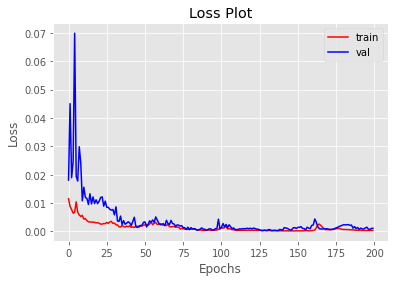

In [21]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MSE = 0.0023778616007532087
RMSE = 0.04876332228994666
R-Squared Score = 0.69459121724879
MAE =  0.04300403354439645


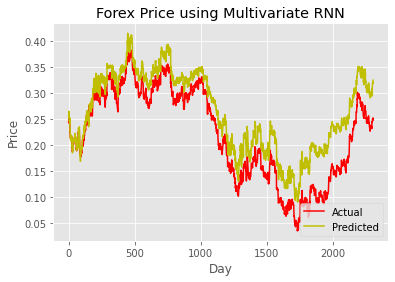

In [22]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,30)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
print("MAE = ", mean_absolute_error(true, predicted))
plot_data(true,predicted,"Forex Price using Multivariate RNN")

In [34]:
predicted

array([[0.2600759 ],
       [0.2526732 ],
       [0.26536036],
       ...,
       [0.32115957],
       [0.318564  ],
       [0.32549027]], dtype=float32)

## Linear Regression

In [23]:
data_s = data_new[['close','open_1','close_1','high_1','low_1','avg_price_5','avg_price_30','avg_price_90','avg_price_365','return_1',
                   'return_5','return_30','return_90','return_365','moving_avg_5','moving_avg_30','moving_avg_365']] # Picking the multivariate series 
print(data_s.shape)
print(data_s.tail())

(14368, 17)
                       close   open_1  close_1   high_1    low_1  avg_price_5  \
Date                                                                            
2012-09-27 21:00:00  1.29355  1.23530  1.23512  1.23609  1.23500     1.235418   
2012-09-27 23:00:00  1.29323  1.23512  1.23444  1.23513  1.23376     1.235100   
2012-09-28 01:00:00  1.29242  1.23444  1.23687  1.23735  1.23432     1.235440   
2012-09-28 03:00:00  1.29447  1.23687  1.23683  1.23726  1.23431     1.235712   
2012-09-28 05:00:00  1.29374  1.23683  1.23595  1.23809  1.23533     1.235842   

                     avg_price_30  avg_price_90  avg_price_365  return_1  \
Date                                                                       
2012-09-27 21:00:00      1.231420      1.232717       1.227113 -0.000146   
2012-09-27 23:00:00      1.231460      1.232635       1.227101 -0.000551   
2012-09-28 01:00:00      1.231593      1.232589       1.227095  0.001969   
2012-09-28 03:00:00      1.231761      1

In [24]:
# Train Val Test Split
train_start = dt.datetime(2007, 11, 22, 17, 00, 00)
train_end = dt.datetime(2011, 6, 30, 23, 00, 00)
train_data = data_s.loc[train_start:train_end]

test_start = dt.datetime(2011, 7, 1, 00, 00, 00)
test_end = dt.datetime(2012, 9, 28, 5, 00, 00)
test_data = data_s.loc[test_start:test_end]

print(train_data.shape,test_data.shape)

(10463, 17) (3905, 17)


In [25]:
X_train = train_data.drop('close', axis='columns')
y_train = train_data['close']

X_test = test_data.drop('close', axis='columns')
y_test = test_data['close']

#checking the shape of the train and test data
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10463, 16), (3905, 16), (10463,), (3905,))

RMSE: 0.0541000229
MAE: 0.0450607941
R^2: 0.2573487797


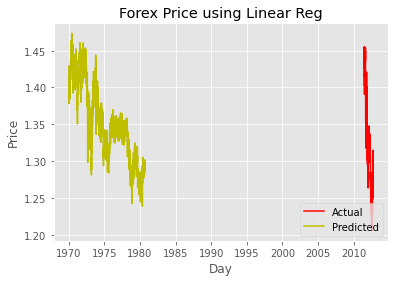

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
lin = LinearRegression()

lin.fit(X_train, y_train)
predictions_lin = lin.predict(X_test)

print('RMSE: {0:.10f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.10f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.10f}'.format(r2_score(y_test, predictions_lin)))
plot_data(y_test,predictions_lin,"Forex Price using Linear Reg")

In [27]:
from sklearn import svm
from sklearn.svm import SVR

# First, let's choose which kernel is the best for our data

for k in ['linear','poly','rbf','sigmoid']:
    clf = svm.SVR(kernel=k)
    clf.fit(X_train, y_train)
    confidence = clf.score(X_train, y_train)
    print(k,confidence)

linear 0.5564061352248133
poly 0.5710980211634475
rbf 0.5762286805402458
sigmoid -27656.827431106085


In [28]:
Svr=SVR(kernel='rbf', C=1, gamma= 0.5)   # Parameter Tuning to get the best accuracy

# Intuitively, the gamma defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’.
# The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. 
# For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. 
# A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. 
# In other words C behaves as a regularization parameter in the SVM.

Svr.fit(X_train,y_train)
print(Svr.score(X_train,y_train))

0.6021299966127541


In [29]:
error = sqrt(mean_squared_error(y_test,Svr.predict(X_test))) #calculate rmse
print('RMSE value of the SVR Model is:', sqrt(mean_squared_error(y_test,Svr.predict(X_test))))
print('MSE value of the SVR Model is:', (mean_squared_error(y_test,Svr.predict(X_test))))
print('R2 score value of the SVR Model is:', (r2_score(y_test,Svr.predict(X_test))))
print('MAE value of the SVR Model is:', (mean_absolute_error(y_test,Svr.predict(X_test))))

RMSE value of the SVR Model is: 0.046811140190635606
MSE value of the SVR Model is: 0.00219128284594734
R2 score value of the SVR Model is: 0.443982526675038
MAE value of the SVR Model is: 0.038304644957470935


In [30]:
Svr.predict(X_test)[0:5]  # print the first 5 predictions of our test set

array([1.41615581, 1.41601702, 1.40946006, 1.40685777, 1.3975393 ])

In [31]:
Svr=SVR(kernel='rbf', C=0.1, gamma= 0.5)   # Parameter Tuning to get the best accuracy

Svr.fit(X_train,y_train)
print(Svr.score(X_train,y_train))

error = sqrt(mean_squared_error(y_test,Svr.predict(X_test))) #calculate rmse
print('RMSE value of the SVR Model is:', sqrt(mean_squared_error(y_test,Svr.predict(X_test))))
print('MSE value of the SVR Model is:', (mean_squared_error(y_test,Svr.predict(X_test))))
print('R2 score value of the SVR Model is:', (r2_score(y_test,Svr.predict(X_test))))
print('MAE value of the SVR Model is:', (mean_absolute_error(y_test,Svr.predict(X_test))))

0.5822015056186145
RMSE value of the SVR Model is: 0.04266346656547718
MSE value of the SVR Model is: 0.0018201713793835894
R2 score value of the SVR Model is: 0.538148581204384
MAE value of the SVR Model is: 0.03522307449800574


0.57023897280649
RMSE value of the SVR Model is: 0.04067881132937682
MSE value of the SVR Model is: 0.001654765691171036
R2 score value of the SVR Model is: 0.5801187234904932
MAE value of the SVR Model is: 0.03389201262626059


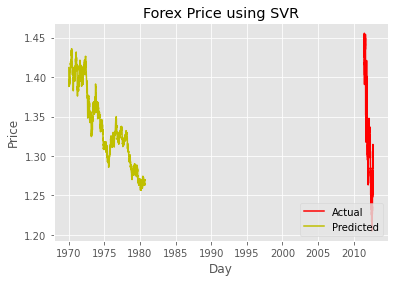

In [32]:
Svr=SVR(kernel='poly', C=0.01, gamma= 0.5)   # Parameter Tuning to get the best accuracy

Svr.fit(X_train,y_train)
print(Svr.score(X_train,y_train))

error = sqrt(mean_squared_error(y_test,Svr.predict(X_test))) #calculate rmse
print('RMSE value of the SVR Model is:', sqrt(mean_squared_error(y_test,Svr.predict(X_test))))
print('MSE value of the SVR Model is:', (mean_squared_error(y_test,Svr.predict(X_test))))
print('R2 score value of the SVR Model is:', (r2_score(y_test,Svr.predict(X_test))))
print('MAE value of the SVR Model is:', (mean_absolute_error(y_test,Svr.predict(X_test))))
plot_data(y_test,Svr.predict(X_test),"Forex Price using SVR")

## GRU

In [39]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
  
    # Adding Layers to the model
    model = Sequential()
    model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
    model.add(GRU(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']
  

In [40]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r2 = r2_score(Y_test,Y_hat)
    mae = mean_absolute_error(Y_test,Y_hat)
    return mse,rmse, r2, mae, Y_test, Y_hat
  

In [41]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title("Forex Price Prediction using Multivariate-GRU")
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [42]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.title('Loss Plot')
    plt.legend(['train','val'],loc = 'lower right')
    plt.show()

### Model Building

In [43]:
# Extracting the series
series = data_new[['close','open_1','close_1','high_1','low_1','avg_price_5','avg_price_30','avg_price_90','avg_price_365','return_1',
             'return_5','return_30','return_90','return_365','moving_avg_5','moving_avg_30','moving_avg_90','moving_avg_365']] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(14368, 18)
                       close   open_1  close_1   high_1    low_1  avg_price_5  \
Date                                                                            
2012-09-27 21:00:00  1.29355  1.23530  1.23512  1.23609  1.23500     1.235418   
2012-09-27 23:00:00  1.29323  1.23512  1.23444  1.23513  1.23376     1.235100   
2012-09-28 01:00:00  1.29242  1.23444  1.23687  1.23735  1.23432     1.235440   
2012-09-28 03:00:00  1.29447  1.23687  1.23683  1.23726  1.23431     1.235712   
2012-09-28 05:00:00  1.29374  1.23683  1.23595  1.23809  1.23533     1.235842   

                     avg_price_30  avg_price_90  avg_price_365  return_1  \
Date                                                                       
2012-09-27 21:00:00      1.231420      1.232717       1.227113 -0.000146   
2012-09-27 23:00:00      1.231460      1.232635       1.227101 -0.000551   
2012-09-28 01:00:00      1.231593      1.232589       1.227095  0.001969   
2012-09-28 03:00:00      1.231761      1

In [44]:
# Train Val Test Split
train_start = dt.datetime(2007, 11, 22, 17, 00, 00)
train_end = dt.datetime(2010, 12, 31, 11, 00, 00)
train_data = series.loc[train_start:train_end]

val_start = dt.datetime(2011, 1, 2, 17, 00, 00)
val_end = dt.datetime(2011, 12, 30, 15, 00, 00)
val_data = series.loc[val_start:val_end]

test_start = dt.datetime(2012, 1, 1, 21, 00, 00)
test_end = dt.datetime(2012, 9, 28, 5, 00, 00)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(8911, 18) (3121, 18) (2336, 18)


In [45]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(8911, 18) (3121, 18) (2336, 18)


In [46]:
timesteps = 40
hl = [40,35]
lr = 1e-4
batch_size = 64
num_epochs = 200

Epoch 00107: early stopping


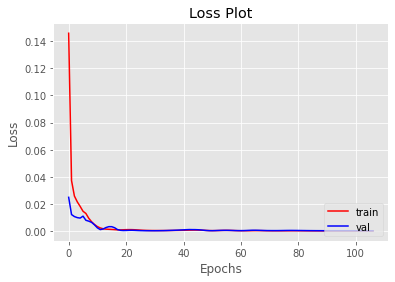

In [49]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MSE = 0.0003979246874131225
RMSE = 0.019948049714524036
R2-Score = 0.9490926012388791
MAE =  0.01594216397216807


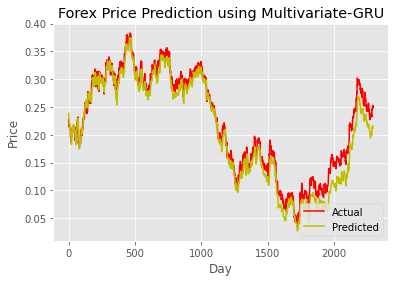

In [50]:
mse,rmse,r2_value,mae,true,predicted = evaluate_model(model,test,40)
print("MSE =",mse)
print("RMSE =",rmse)
print("R2-Score =",r2_value)
print('MAE = ',mae)
plot_data(true,predicted)

## LSTM

In [51]:
from keras.layers.recurrent import LSTM

In [52]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
  
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True, activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error')
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 0,
                        shuffle = False, callbacks=callbacks_list)
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss']


In [53]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    #print(X_test.shape,Y_test.shape)
  
    # Prediction Time !!!!
    Y_hat = model.predict(X_test)
    mse = mean_squared_error(Y_test,Y_hat)
    rmse = sqrt(mse)
    r = r2_score(Y_test,Y_hat)
    return mse, rmse, r, Y_test, Y_hat
  

In [54]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Forex Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [55]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

### Model Building

In [56]:
# Extracting the series
series = data_new[['close','open_1','close_1','high_1','low_1','avg_price_5','avg_price_30','avg_price_90','avg_price_365','return_1',
             'return_5','return_30','return_90','return_365','moving_avg_5','moving_avg_30','moving_avg_90','moving_avg_365']] # Picking the multivariate series 
print(series.shape)
print(series.tail())

(14368, 18)
                       close   open_1  close_1   high_1    low_1  avg_price_5  \
Date                                                                            
2012-09-27 21:00:00  1.29355  1.23530  1.23512  1.23609  1.23500     1.235418   
2012-09-27 23:00:00  1.29323  1.23512  1.23444  1.23513  1.23376     1.235100   
2012-09-28 01:00:00  1.29242  1.23444  1.23687  1.23735  1.23432     1.235440   
2012-09-28 03:00:00  1.29447  1.23687  1.23683  1.23726  1.23431     1.235712   
2012-09-28 05:00:00  1.29374  1.23683  1.23595  1.23809  1.23533     1.235842   

                     avg_price_30  avg_price_90  avg_price_365  return_1  \
Date                                                                       
2012-09-27 21:00:00      1.231420      1.232717       1.227113 -0.000146   
2012-09-27 23:00:00      1.231460      1.232635       1.227101 -0.000551   
2012-09-28 01:00:00      1.231593      1.232589       1.227095  0.001969   
2012-09-28 03:00:00      1.231761      1

In [57]:
# Train Val Test Split
train_start = dt.datetime(2007, 11, 22, 17, 00, 00)
train_end = dt.datetime(2010, 12, 31, 11, 00, 00)
train_data = series.loc[train_start:train_end]

val_start = dt.datetime(2011, 1, 2, 17, 00, 00)
val_end = dt.datetime(2011, 12, 30, 15, 00, 00)
val_data = series.loc[val_start:val_end]

test_start = dt.datetime(2012, 1, 1, 21, 00, 00)
test_end = dt.datetime(2012, 9, 28, 5, 00, 00)
test_data = series.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

(8911, 18) (3121, 18) (2336, 18)


In [58]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(8911, 18) (3121, 18) (2336, 18)


In [59]:
timesteps = 50
hl = [40,35]
lr = 1e-3
batch_size = 64
num_epochs = 250

Epoch 00185: early stopping


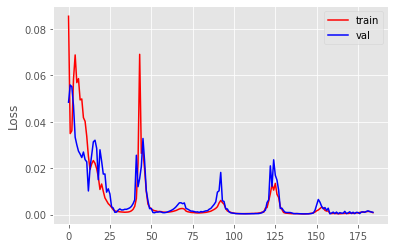

In [60]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

MSE = 0.0010315603302062484
RMSE = 0.03211791291796913
R-Squared Score = 0.8686019385611303
MAE =  0.028069584894581598


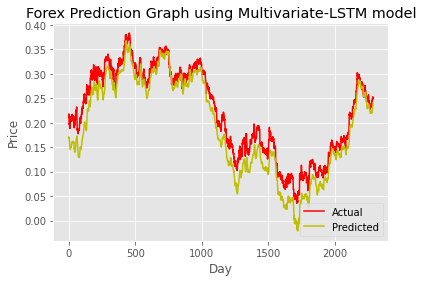

In [61]:
mse, rmse, r2_value,true,predicted = evaluate_model(model,test,timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))
print("MAE = ", mean_absolute_error(true, predicted))
plot_data(true,predicted)

# 